# NLP Pipelines

This package is designed to generalize the fit/predict to entire end to end pipelines for text. It can be used as individual methods or as a pipeline object to manage execution of training and/or testing. See README.md for an overview of which methods are in here.

## This Demo Set

This set of demos walks through:

* **Basic Usage Demos** Using abstract/toy datasets to show how to use this library.
  * **Usage of the library as individual methods**: Using each of the methods manually to get results.
  * **Usage of the pipeline constructor**: A reimplementaiton of the examples above using the pipeline object.
  * **Saving and loading trained pipelines**: Quick guidance on how to separate training and running/prediction.
* **Practical Demos**: With real data and justifying decisions on pipeline design.
  * **Practical Demo: Clustering**: A real end-to-end example on clustering, where "clustering" is picking some set of groups without explicit mapping to classes.
  * **Practical Demo: Classification**: A real end-to-end example on classification, where "classificaiton" is picking which of a set of classes best apply to a document.
  * **Practical Demo: Extractive Labeling**: A real end-to-end example on extractive labeling, where "extractive labeling" is picking which words or phrases in a document "seem important", like automatic keyword extraction.
  * **Practical Demo: Extractive Labeling**: A real end-to-end example on predictive labeling, where a set of possible labels is chosen a prioro, and between none and all of the possible labels may apply to a document.
  * **(WIP) Practical Demo: Mixing Methods**:  A real end-to-end example on using different kinds of methods together to get simpler results.

NOTE that this is not intended to be an exhaustive demo of all of the different methods: `test_demos.ipynb` may be a better choice for that.

## Setup Dependncies
For portability, this is included to install dependencies for this library and notebook itself.

In [1]:
# install dependencies
%pip install -r requirements.txt 

Note: you may need to restart the kernel to use updated packages.


# Basic Usage Demos

## Datasets

We should make different datasets for different pipelines. For this basic usage section, the datasets are fake and chosen unrealistically to demonstrate the shape of the inputs and outputs of the steps and pipelines. We'll need a dataset with no truths (true labels are called "truths" in this library) for clustering and extractive labeling (n.b. this is not strictly necessary, clustering and extractive labeling methods will simply ignore truths, so including them here is likely to be confusing), one with classes for classification, and one with lists of labels as truths for labeling.

In [2]:
from nlp_pipelines.dataset import Dataset

# methods which do not need truths of any form get the unlabeled_dataset.
texts_1 = [
    "I love hiking in the mountains.",
    "The sun is shining bright today.",
    "Reading books is my favorite hobby.",
    "I enjoy outdoor activities like camping.",
    "It's a beautiful day for a walk in the park.",
    "I prefer staying indoors and watching movies.",
    "Cooking new recipes is always fun."
]

unlabeled_dataset = Dataset(texts_1)

# methods which need truth clases (exactly one per document) get the classed_dataset.
texts_2 = [
    "I love this movie",
    "This is terrible",
    "Fantastic work",
    "Awful experience",
    "My favorite film ever",
    "A waste of my time",
    "Not enough people have seen this masterpiece"
    ]
classes = [
    "positive",
    "negative",
    "positive",
    "negative",
    "positive",
    "negative",
    "positive"
    ]
classed_dataset = Dataset(texts_2, classes)

# methods which need truth label sets (0 to n per document) get the labeled_dataset.
texts_3 = [
    "I love baking with things from my garden.",
    "Here's a recipe for lasagna.",
    "I enjoy hiking in the mountains and camping.",
    "I have recenly learned how to cook good food when hiking.",
    "I spent the weekend building a treehouse.",
    "Cooking dinner with fresh ingredients is a joy.",
    "I often take long walks in the park during summer to get inspired on what I should plant."
]

labels = [
    ["cooking", "gardening"],
    ["cooking"],
    ["outdoors"],
    ["outdoors", "cooking"],
    ["outdoors"],
    ["cooking"],
    ["outdoors", "gardening"]
]

labeled_dataset = Dataset(texts_3, labels)

#also, for convenience, let's add an explicit list of possible_labels
possible_labels = ["gardening", "cooking", "outdoors"]




## Usage of the library as individual methods

Now, let's try to get some results for our toy data.



### Clustering
As a reminder, we want to apply clusters on the unlabeled dataset.
For now, we'll judge the results on what *feels* right for such a small dataset with no truth for comparison; proper evaluation will be explored in the next section on real data.

In [3]:

# let's make a copy of our data as not to interfere with any other runs
import copy

cluster_dataset = copy.deepcopy(unlabeled_dataset)

#Our goal is to see which clusters the data is in, rather than to use the clusters to classify new data, so we can use the same data to fit and predict without splitting, just using cluster_dataset

# we need a vectorizer to put this into a form which we can do math on. So we can use one thing for all, we'll use the sentence embedding model ('all-MiniLM-L6-v2)

# import
from nlp_pipelines.vectorizer import SentenceEmbedding

# initialize
embedding_model = SentenceEmbedding(model_name='all-MiniLM-L6-v2') # "all-MiniLM-L6-v2" is the default for this method, but let's make it explicit
# this is a pretrained embedding model which uses context to take a chunk of text and return a vector which is meant to represent the text in some high dimensional space. See (https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) for details of this particular model; the website should also have other options for sentence embeddings, which may be more well suited to particular tasks, possibly with computational tradeoffs.

# while sentence embeddings typically do well with the full sentence uncleaned, we'll also remove uninformative words and stem, to make the sentences simpler.

# import
from nlp_pipelines.preprocess import StopwordRemove, Stem

# initalize
stopword_remover = StopwordRemove() # remove uninformative words
stemmer = Stem() # find the roots of words

# let's use k-means with k=2 for the clustering

#import
from nlp_pipelines.clusterer import Kmeans

# initalize
kmeans_model = Kmeans(num_clusters=2, random_state=101) # picks 2 points in embedding space as centroids; documents are assigned to closest centroid

# ok, now we need to run these on the dataset in order. Preprocess, then vectorize, then cluster.

# each of the methods needs to be fit and transoformed/predicted on the data.
print("initial data:", cluster_dataset)
stopword_remover.fit(cluster_dataset)
cluster_dataset = stopword_remover.transform(cluster_dataset) # keep working on this object "cluster_dataset" step by step
print("after stopword remove:", cluster_dataset)
stemmer.fit(cluster_dataset)
cluster_dataset = stemmer.transform(cluster_dataset)
print("after stemming:", cluster_dataset)
embedding_model.fit(cluster_dataset)
cluster_dataset = embedding_model.transform(cluster_dataset)
print("after vectorization:", cluster_dataset)
kmeans_model.fit(cluster_dataset)
cluster_dataset = kmeans_model.predict(cluster_dataset)
print("after k-means:", cluster_dataset)

# finally, let's just look at the results and original texts side by side
print("original text:", cluster_dataset.original_texts)
print("cluster results:", cluster_dataset.results)


/opt/homebrew/Caskroom/miniconda/base/envs/spade/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


initial data: <Dataset with 7 texts
Texts: ['I love hiking in the mountains.', 'The sun is shining bright today.']... +5 more>
after stopword remove: <Dataset with 7 texts
Texts: ['love hiking mountains', 'sun shining bright today']... +5 more>
after stemming: <Dataset with 7 texts
Texts: ['love hike mountain', 'sun shine bright today']... +5 more>
after vectorization: <Dataset with 7 texts, vectors: 384-dim
Texts: ['love hike mountain', 'sun shine bright today']... +5 more>
after k-means: <Dataset with 7 texts, vectors: 384-dim, results: 7 items
Texts: ['love hike mountain', 'sun shine bright today']... +5 more
Results: [1 1]... +5 more>
original text: ['I love hiking in the mountains.', 'The sun is shining bright today.', 'Reading books is my favorite hobby.', 'I enjoy outdoor activities like camping.', "It's a beautiful day for a walk in the park.", 'I prefer staying indoors and watching movies.', 'Cooking new recipes is always fun.']
cluster results: [1 1 1 0 1 0 0]


/opt/homebrew/Caskroom/miniconda/base/envs/spade/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Extractive Labeling (Keyword Extraction)

Labeling is getting 0+ "labels" per document. the simpler version of this is extractive labeling, more commonly referred to as keyword extraction. The problem is usually framed as having a large text and wanting to get especially important/informative keywords. These are not picked from a user-supplied set, and are extracted from the text. Since the text is extracted, and there are multiple labels per document, I've called this extractive labeling for internal naming consistency.

Anyway, we can do the same preprocessing as we did, but we don't need to vectorize, since this method works on the text itself, rather than in an embedding space. We /could/ reuse the same dataset which already has these transformations and overwrite the results, but for now, let's do it from scratch for clarity.

In [4]:
# preprocessing methods were already imported above, let's re-initialize them for clarity (agin we don't /need/ to do this, we could simply fit to overwrite any information the methods got during preprocessing [in this case there's none]).

stopword_remover = StopwordRemove() # remove uninformative words
stemmer = Stem() # find the roots of words

# TfidfTopN is a method which uses Term Frequency Inverse Document (corpus) frequency to find informative words, then just picks the top N on that score.
# more or less, think of this mathod as returning words which are rare across the corpus but generally but show up in this document a lot.

from nlp_pipelines.labeler import TfidfTopN

# initalize
tfidf_labeler = TfidfTopN(top_k=2, ngram_range=(1,3)) # 2 keywords per thing, up to 3gram keywords

# a fresh copy of the source dataset again
extractive_dataset = copy.deepcopy(unlabeled_dataset)

# fit and transform/predict each method

print("initial data:", extractive_dataset)
stopword_remover.fit(extractive_dataset)
extractive_dataset = stopword_remover.transform(extractive_dataset) # keep working on this object "cluster_dataset" step by step
print("after stopword remove:", extractive_dataset)
stemmer.fit(extractive_dataset)
extractive_dataset = stemmer.transform(extractive_dataset)
print("after stemming:", extractive_dataset)
tfidf_labeler.fit(extractive_dataset)
extractive_dataset = tfidf_labeler.predict(extractive_dataset)
print("after labeling:", extractive_dataset)

# finally, let's just look at the results and original texts side by side
print("original text:", extractive_dataset.original_texts)
print("labeling results:", extractive_dataset.results)

initial data: <Dataset with 7 texts
Texts: ['I love hiking in the mountains.', 'The sun is shining bright today.']... +5 more>
after stopword remove: <Dataset with 7 texts
Texts: ['love hiking mountains', 'sun shining bright today']... +5 more>
after stemming: <Dataset with 7 texts
Texts: ['love hike mountain', 'sun shine bright today']... +5 more>
after labeling: <Dataset with 7 texts, results: 7 items
Texts: ['love hike mountain', 'sun shine bright today']... +5 more
Results: [['love', 'mountain'], ['bright today', 'sun shine']]... +5 more>
original text: ['I love hiking in the mountains.', 'The sun is shining bright today.', 'Reading books is my favorite hobby.', 'I enjoy outdoor activities like camping.', "It's a beautiful day for a walk in the park.", 'I prefer staying indoors and watching movies.', 'Cooking new recipes is always fun.']
labeling results: [['love', 'mountain'], ['bright today', 'sun shine'], ['read book', 'book'], ['activ', 'camp'], ['day walk park', 'walk park'], 

### Classification

The pattern for classification is straightforward: one document gets one class. It's much like clustering, but we expect it to match the meaning of the class, rather than just membership. 

This time, however, let's use a supervised method. This also means we should split the dataset into test and train.

In [5]:
train, test = classed_dataset.split(count=3, seed=101) # 3 in train, the other four in test

print("train split:", train)
print("test split:", test)

# we've already seen preprocessing, but once more:
stopword_remover = StopwordRemove() # remove uninformative words
stemmer = Stem() # find the roots of words

# let's use a bag of words embedding this time. This is not pretrained, so fit will actually learn something about the data. This does, however, mean that words/tokens in the test/predict data which were not in the train data will essentially be ignored under embedding. In real applciations, use a well-rounded train set.

from nlp_pipelines.vectorizer import BagOfWords

bag_of_words_embed = BagOfWords() # no arguments, just counts! Bag of words assigns each word/token an index for all vectors, and its value is the number of times it appears.

# let's use label propogation. This is usually referred to as semi-supervised, but we can fit it on the train data then use the space of those labeled documents in the vector space to label the new documents.

from nlp_pipelines.classifier import LabelProp

label_prop_model = LabelProp(n_neighbors=2, kernel="rbf") #by default, the kernel is knn which is probably good enough, but we're customizing here to show how to do so

# ok, let's fit the train data.
stopword_remover.fit(train)
train = stopword_remover.transform(train)
stemmer.fit(train)
train = stemmer.transform(train)
bag_of_words_embed.fit(train)
train = bag_of_words_embed.transform(train)
train = stemmer.transform(train)
label_prop_model.fit(train)
# no point in transforming, each would map to itself.

# now we have each of these fit, we run it again for the test data
test = stopword_remover.transform(test)
test = stemmer.transform(test)
test = bag_of_words_embed.transform(test)
test = label_prop_model.predict(test)

# look at the results
print("original text for test split:", test.original_texts)
print("results from label propagation: ", test.results)
print("comparison: set truths", test.truths)

# also, we can evaluate, since our results and truths are speaking the same language 

from nlp_pipelines.evaluate import evaluate

print("Result evaluation", evaluate(test))


train split: <Dataset with 3 texts
Texts: ['This is terrible', 'My favorite film ever']... +1 more
Truths: ['negative', 'positive']... +1 more>
test split: <Dataset with 4 texts
Texts: ['I love this movie', 'Fantastic work']... +2 more
Truths: ['positive', 'positive']... +2 more>
original text for test split: ['I love this movie', 'Fantastic work', 'Awful experience', 'A waste of my time']
results from label propagation:  ['negative' 'negative' 'negative' 'negative']
comparison: set truths ['positive', 'positive', 'negative', 'negative']
Result evaluation {'accuracy': 0.5, 'precision_macro': 0.25, 'recall_macro': 0.5, 'f1_macro': 0.3333333333333333}


## Usage of the pipeline constructor

In the last part, we had a series of operations which needed to be fit then transformed. That's workable when we have all of the data at once, but we'd probably like to be able to do more later. We should save our method! However, like this this means that we'd have to save every step, and when we wanted to use it again, we'd need to use them in the same order. Remember that our methods which rely on a particular embedding space would likely break under another.

To solve this, and also to make using this easier, a helper class "Pipeline" is used. This makes saving/loading pretrained pipelines much more workable. Also, I think it's easier to read and does not distract from the core of what the pipeline is doing.

For a quick demo, let's remake the previous pipelines using Pipeline objects.

In [6]:
from nlp_pipelines.pipeline import Pipeline

# clustering from previous subsecton reproduced!

cluster_pipeline = Pipeline([
    {"name": "preprocess_1", "method": "preprocess.StopwordRemove"}, # each line has the method,  the name field is just for readability
    {"name": "preprocess_2", "method": "preprocess.Stem"}, # the method names are very similar to how the methods were imported; from nlp_pipelines.X import Y becomes X.Y for X and Y. The methods are listed in README.md
    {"name": "vectorize", "method":"vectorizer.SentenceEmbedding", "params":{"model_name":'all-MiniLM-L6-v2'}}, # the parameters passed when initializing the method are passed as "params" if needed
    {"name": "kmeans", "method": "clusterer.Kmeans", "params":{"num_clusters":2, "random_state":101}}
])

cluster_dataset = copy.deepcopy(unlabeled_dataset)

cluster_pipeline.set_data(train_data=cluster_dataset, run_data=cluster_dataset) # same train and run data for now

# run it! This is an alias for .fit and .predict
cluster_pipeline.run()
# get the results from the run_data
print("original text:", cluster_pipeline.run_data.original_texts)
print("preprocessed text:", cluster_pipeline.run_data.texts)
print("resulting clusters:", cluster_pipeline.run_data.results)

original text: ['I love hiking in the mountains.', 'The sun is shining bright today.', 'Reading books is my favorite hobby.', 'I enjoy outdoor activities like camping.', "It's a beautiful day for a walk in the park.", 'I prefer staying indoors and watching movies.', 'Cooking new recipes is always fun.']
preprocessed text: ['love hike mountain', 'sun shine bright today', 'read book favorit hobbi', 'enjoy outdoor activ like camp', 'beauti day walk park', 'prefer stay indoor watch movi', 'cook new recip fun']
resulting clusters: [1 1 1 0 1 0 0]


In [7]:
# extractive labeling from previous subsecton reproduced!

extract_pipeline = Pipeline([
    {"name": "preprocess_1", "method": "preprocess.StopwordRemove"},
    {"name": "preprocess_2", "method": "preprocess.Stem"},
    {"name": "tfidf keyword extract", "method": "labeler.TfidfTopN", "params":{"top_k":2, "ngram_range":(1,3)}}
])

extractive_dataset = copy.deepcopy(unlabeled_dataset)

extract_pipeline.set_data(train_data=extractive_dataset, run_data=extractive_dataset) # same train and run data for now, again since no split

# run it! This is an alias for .fit and .predict
extract_pipeline.run()
# get the results from the run_data
print("original text:", extract_pipeline.run_data.original_texts)
print("preprocessed text:", extract_pipeline.run_data.texts)
print("resulting keyword sets:", extract_pipeline.run_data.results)

original text: ['I love hiking in the mountains.', 'The sun is shining bright today.', 'Reading books is my favorite hobby.', 'I enjoy outdoor activities like camping.', "It's a beautiful day for a walk in the park.", 'I prefer staying indoors and watching movies.', 'Cooking new recipes is always fun.']
preprocessed text: ['love hike mountain', 'sun shine bright today', 'read book favorit hobbi', 'enjoy outdoor activ like camp', 'beauti day walk park', 'prefer stay indoor watch movi', 'cook new recip fun']
resulting keyword sets: [['love', 'day walk'], ['today', 'sun'], ['watching movies', 'day walk'], ['like', 'outdoor'], ['day walk', 'walk park'], ['prefer', 'watching movies'], ['new', 'fun']]


## Saving and loading trained pipeline

For the classifier, we had to fit a lot! It's a good case to save and load a pipeline: there's seprate data, and both the vectorizer and the model have changed from .fit. Let's do the same thing this time though let's pretend we're picking it up after some time and save/load the pipeline.

In [8]:
# classification from previous subsecton reproduced!

extract_pipeline = Pipeline([
    {"name": "preprocess_1", "method": "preprocess.StopwordRemove"},
    {"name": "preprocess_2", "method": "preprocess.Stem"},
    {"name": "bow vectorize", "method": "vectorizer.BagOfWords"},
    {"name": "classifier labelprop", "method": "classifier.LabelProp", "params":{"n_neighbors":2, "kernel":"rbf"}}
])

train, test = classed_dataset.split(count=3, seed=101)

extract_pipeline.set_data(train_data=train) # just need train data to train
extract_pipeline.train()

extract_pipeline.save("./demo_data/toy_classifier.pickle")

# let's load it
loaded_pipeline = Pipeline.load("./demo_data/toy_classifier.pickle")
# now let's load the test data and run the saved pretrained pipeline on that
loaded_pipeline.set_data(run_data=test)
loaded_pipeline.predict()

# get the results from the run_data
print("original text:", loaded_pipeline.run_data.original_texts)
print("preprocessed text:", loaded_pipeline.run_data.texts)
print("resulting classes:", loaded_pipeline.run_data.results)
print("true classes:", loaded_pipeline.run_data.truths)

# and again, evaluate
print("evaluation of classes:", evaluate(loaded_pipeline.run_data))

# see, just the same! but easier!

original text: ['I love this movie', 'Fantastic work', 'Awful experience', 'A waste of my time']
preprocessed text: ['love movi', 'fantast work', 'aw experi', 'wast time']
resulting classes: ['negative' 'negative' 'negative' 'negative']
true classes: ['positive', 'positive', 'negative', 'negative']
evaluation of classes: {'accuracy': 0.5, 'precision_macro': 0.25, 'recall_macro': 0.5, 'f1_macro': 0.3333333333333333}


# Practical Demos

Let's load some real data (`./demo_data`)

`sample_5_newsgroup_text.parquet` contains text posted in 5 newsgroups, with labels; adapted from [SetFit/20_newsgroups](https://huggingface.co/datasets/SetFit/20_newsgroups). The text is a given post in the group, and the class is the source newsgroup. There are some semantic overlaps (e.g. multiple are about computers), so it's more challenging than an artificial clean dataset.

`springer-127-parsed.json` contains abstracts and keywords from the journal [Social Psychiatry and Psychiatric Epidemiology](https://link.springer.com/journal/127). There are a number of abstract terms, and as a result the assigned keywords are likely to be much broader than subsets we consider, though preprocessing the labels could help with that.

Unlike the above, these demos are not as much to show how to use the methods, but are more of a real-time attempt at genuine problemsolving.

In [9]:
# the newsgroups are in a parquet file, which is like a compressed csv but not directly human readable.
newsgroups = Dataset.from_parquet("./demo_data/sample_5_newsgroup_text.parquet", text_field="text", truth_field="label_text")

# the abstracts are in a json file, which is a usual web serialization
abstracts = Dataset.from_json("./demo_data/springer-127-parsed.json", text_field="abstract", truth_field="keywords")

## Clustering

The best choice to do clustering is the newsgroups data, as the methods here only cluster into a single class.
The evaluate function can still be used here, it will just map the "best" case between labels and clusters, essentially giving the cluster results the benefit of the doubt. Though, it seems reasonable that if we had n clusters and n labels, we'd pick the best match anyway.

Thinking more about the design of this pipeline, there's room for a bigger comparison. Previous work on this combined methods with vectorizations. But, we can now keep the same method and compare results between different vectorizations. (Note: It's also entirely possible that the dimension could be the core of the difference, I'm saying in advance of actually running things, but this could be explored further later).

So, from my understanding of the sentence embedding, it does better with raw information; it's meant to feed a BERT model, which as a transformer LLM is likely to perform better with sentences than stemmed words or stopwords removed.

However, for comparison, we can use the simplest embedding, BagOfWords. To get more out of this, we'll lean more on preprocessing.

(For later consideration, further expirements seem interesting in comparison more like to like: how much better does a bigger pretrained sentence embedding do all else the same? Does my reasoning about preprocessing actually hold true?)

Anyway, let's use a very simple clustering method: K-means, trained and evaluated on the same dataset but of course different embedding spaces.

In [10]:
train, test = newsgroups.split(ratio=0.8, labeled=True, splitLabeled=True, seed=101) # discard all non-labeled data, from both train and test.

print("Train split:", train, "\n")
print("Test split:", test, "\n")

# also, I think python copies by reference, and these pipelines will both want to write to .results. Let's make a copy for each. 
train_1 = copy.deepcopy(train)
test_1 = copy.deepcopy(test)
train_2 = copy.deepcopy(train)
test_2 = copy.deepcopy(test)

embed_pipeline = Pipeline([
    {"name": "vectorize", "method":"vectorizer.SentenceEmbedding", "params":{"model_name":'all-MiniLM-L6-v2'}},
    {"name": "kmeans", "method": "clusterer.Kmeans", "params":{"num_clusters":5, "random_state":101}}
])

embed_pipeline.set_data(train_data=train_1, run_data=test_1)

bow_pipeline = Pipeline([
    {"name": "preprocess_1", "method": "preprocess.StopwordRemove"},
    {"name": "preprocess_2", "method": "preprocess.Stem"},
    {"name": "bow vectorize", "method": "vectorizer.BagOfWords"},
    {"name": "kmeans", "method": "clusterer.Kmeans", "params":{"num_clusters":5, "random_state":101}}
])

bow_pipeline.set_data(train_data=train_2, run_data=test_2)

embed_pipeline.run()
bow_pipeline.run()

print("Embed Pipeline Results: \n", evaluate(embed_pipeline.run_data, cluster_mode=True), "\n")
print("Bag of words Pipeline Results: \n", evaluate(bow_pipeline.run_data, cluster_mode=True), "\n")

Train split: <Dataset with 100 texts
Texts: ['We are working on gas-solid adsorption air-con system for auto applications.\nIn this kind of system, the energy for regenerating the adsorbent is from \nthe exhaust gas.  Anyone interested in this mail email me or follow up this\nthread, we may have a discussion on prospects of this technology.\n\nMax \n', 'My boss is considering the purchase of a Powerbook or Duo. He is leaning\ntowards a 180, because of the math coprocessor (for Mathematica), but would\nget a Duo if he could find a Mini-Dock with a coprocessor. Have any\nthird-parties announced such a beast?\n']... +98 more
Truths: ['rec.autos', 'comp.sys.mac.hardware']... +98 more> 

Test split: <Dataset with 400 texts
Texts: ["\n\n\n\n\n\nIt's a fair stretch of anyone's imagination to expect them to\nattach any credibility to anything written in Time magazine in\nthe past twenty years, I'd imagine.  The Enquirer at least gets\nthe names attached to the right body parts.\n\n=Mark\n--", 

Wow, honestly I thought it'd be a little closer!

In any case, we have some new and old metrics. We needn't focus on all of them practically, but as a review:

* Expected Metrics
  * accuracy: How many were right?
  * f1_macro: the average across each class of the f1 scores, where the f1 score is the harmonic mean of precision and recall.
* Cluster Metrics
  * Adjusted Rand Index (ARI): How similar the results are to the truths, adjusted such that the expectation of ARI for random assignment is 0 (so it can be negative if worse than expected by random chance!). Quick way to tell how the results compare to random noise.
  * Normalized Mutual Information (NMI): Shared information between clusrters, also normalized (but still [0,1]).
  * V measure: Harmonic mean of homogeneity (each cluster contains one class) and completeness (all class members in one cluster). Captures/generalizes purity information.
  * Fowlkes-Mallows: Geometric mean of precision and recall for clustering pairs. 

## Classification

I want to take this as an opportunity to contextualize prior results to a (reasonably simple) deep learning model. We haven't had much data here, but NNs can be powerful. Let's compare a simple NN (new class: two layer NN with a dropout term) to both label propagation and the xgboost method. Using the same embedding with no major preprocessing.

In [11]:
# first, let's get the possible labels for this dataset

newsgroup_labels = list(set(newsgroups.truths)) # quick way to get all unique labels in a flat list!
print(newsgroup_labels)

['rec.autos', 'sci.space', 'comp.graphics', 'comp.sys.mac.hardware', 'talk.politics.guns']


In [12]:
# again, out of an abundance of caution making copies.
train_3 = copy.deepcopy(train)
test_3 = copy.deepcopy(test)
train_4 = copy.deepcopy(train)
test_4 = copy.deepcopy(test)
train_5 = copy.deepcopy(train)
test_5 = copy.deepcopy(test)

nn_pipeline = Pipeline([
    {"name": "vectorize", "method":"vectorizer.SentenceEmbedding", "params":{"model_name":'all-MiniLM-L6-v2'}},
    {"name": "nn", "method": "classifier.SimpleNNClassifier"}
])

nn_pipeline.set_data(train_data=train_3, run_data=test_3, possible_labels=newsgroup_labels)

labelprop_pipeline = Pipeline([
    {"name": "vectorize", "method":"vectorizer.SentenceEmbedding", "params":{"model_name":'all-MiniLM-L6-v2'}},
    {"name": "labelprop", "method": "classifier.LabelProp"}
])

labelprop_pipeline.set_data(train_data=train_4, run_data=test_4, possible_labels=newsgroup_labels)

xgboost_pipeline = Pipeline([
    {"name": "vectorize", "method":"vectorizer.SentenceEmbedding", "params":{"model_name":'all-MiniLM-L6-v2'}},
    {"name": "xgboost", "method": "classifier.Xgboost"}
])

xgboost_pipeline.set_data(train_data=train_5, run_data=test_5, possible_labels=newsgroup_labels)


nn_pipeline.run()
labelprop_pipeline.run()
xgboost_pipeline.run()

In [13]:
print("Neural Net Pipeline Results: \n", evaluate(nn_pipeline.run_data), "\n")
print("Label Propagation Pipeline Results: \n", evaluate(labelprop_pipeline.run_data), "\n")
print("Xgboost Pipeline Results: \n", evaluate(xgboost_pipeline.run_data), "\n")

Neural Net Pipeline Results: 
 {'accuracy': 0.5075, 'precision_macro': 0.5250816229763599, 'recall_macro': 0.5252549941245593, 'f1_macro': 0.39630672387823945} 

Label Propagation Pipeline Results: 
 {'accuracy': 0.7625, 'precision_macro': 0.7786128740012235, 'recall_macro': 0.7654396508309552, 'f1_macro': 0.7624544524195012} 

Xgboost Pipeline Results: 
 {'accuracy': 0.6475, 'precision_macro': 0.6477712904911181, 'recall_macro': 0.6449753231492362, 'f1_macro': 0.6424181929441555} 



(And again, _macro means we averaged across classes, not just documents.)

## Extractive Labeling

Extractive labeling is simply picking words from a document which seem especially important. It's typically used for keyword extraction, and could be seen as a special kind of summarization. I'm curious about the difference across the corpus of extracted keywords versus the "true" keywords. I'm also curious how essential filtering out words in a step of preprocessing is

In [16]:
# make copies of abstracts
abstracts_1 = copy.deepcopy(abstracts)
abstracts_2 = copy.deepcopy(abstracts)

# pipeline 1: lemmatize, keyword extract
lemmatize_pipeline = Pipeline([
    {"name": "lemmatize", "method":"preprocess.Lemmatize"},
    {"name": "keywords", "method": "labeler.KeyBert"}
])

lemmatize_pipeline.set_data(train_data=abstracts_1, run_data=abstracts_1)

# pipeline 2: filter out some kinds of words, lemmatize, keyword extract
filter_pipeline = Pipeline([
    {"name": "filter", "method":"preprocess.TokenFilter", "params":{"remove_if":["is_stop", "is_punct", "is_space", "like_num", "like_url"]}}, # see https://spacy.io/api/token/#attributes
    {"name": "lemmatize", "method":"preprocess.Lemmatize"},
    {"name": "keywords", "method": "labeler.KeyBert"} 
])

filter_pipeline.set_data(train_data=abstracts_2, run_data=abstracts_2)

lemmatize_pipeline.run()
filter_pipeline.run()

<Dataset with 500 texts, results: 500 items
Texts: ['purpose Disparities mental health sexual orientation group young adult long discuss aim cross sectional study investigate moderate effect sexual orientation association social factor depressive symptom suicidal ideation young adult method study include participant age 18–25y French EpiCov cohort outcome variable depressive symptom suicidal ideation Poisson regression robust error variance perform investigate association social factor outcome accord sexual orientation lesbian gay bisexual defining accord sexuality sexual minority SM heterosexual wishing answer belong SM NSM result prevalence depressive symptom suicidal ideation high SM NSM group depressive symptom significant moderate effect sexual orientation observe female vs male sex NSM adjust prevalence ratio apr 1.58[1.28–1.95 SM apr 1.03[0.78–1.36 age category 22–25y vs 21y nsm apr 1.32[1.05–1.67 sm apr 0.78[0.59–1.03 suicidal ideation significant moderate effect observe vs rel

Ok, now let's look at these pipelines comared to each other, and to the true labels. 


Number of keywords only in Results: 555
Number of keywords only in Truths: 1230
Number of keywords in both Results and Truths (intersection): 209

Top keywords in Results by count:
depression: 81
psychiatric: 48
depressive: 47
suicide: 46
adolescent: 46
prevalence: 39
anxiety: 36
schizophrenia: 35
psychosis: 34
health: 32

Top keywords in Truths by count:
mental health: 75
depression: 65
schizophrenia: 32
covid-19: 29
suicide: 29
anxiety: 26
loneliness: 23
psychosis: 19
epidemiology: 18
mental disorders: 17


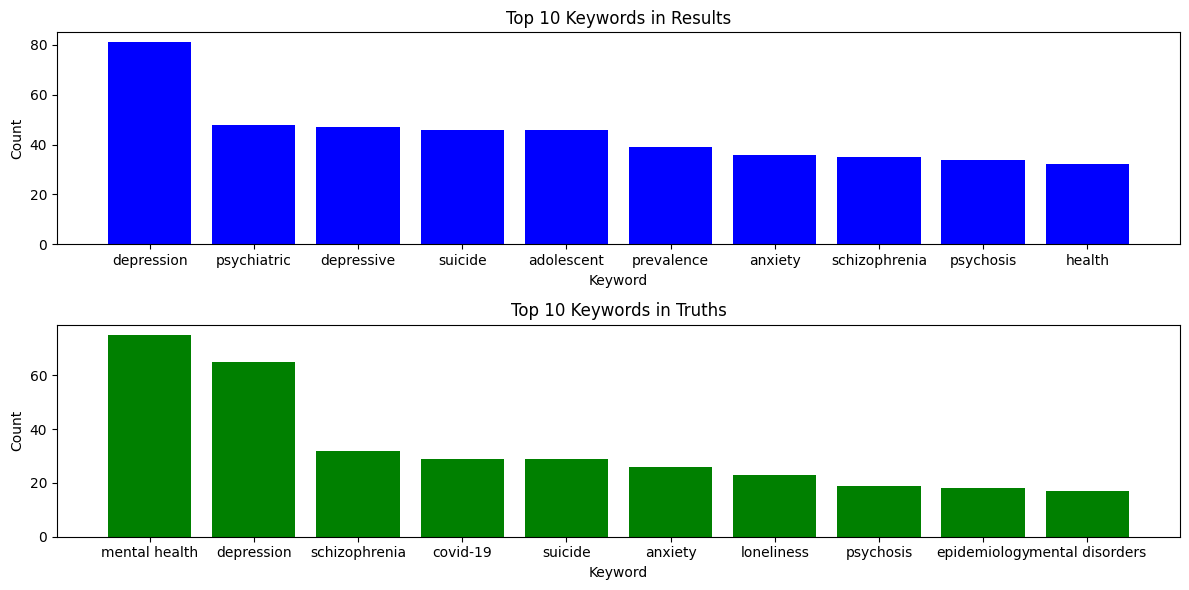

In [24]:
import matplotlib.pyplot as plt
from collections import Counter

# Flatten the lists of lists into single lists, make lowercase
flat_a = [item.lower() for sublist in lemmatize_pipeline.run_data.results for item in sublist]
flat_b = [item.lower() for sublist in lemmatize_pipeline.run_data.truths for item in sublist]

set_a = set(flat_a)
set_b = set(flat_b)

intersection = set_a & set_b
only_a = set_a - set_b
only_b = set_b - set_a

# how many distinct keywords are in results, truths, and both
print(f"Number of keywords only in Results: {len(only_a)}")
print(f"Number of keywords only in Truths: {len(only_b)}")
print(f"Number of keywords in both Results and Truths (intersection): {len(intersection)}\n")

# Count occurrences of keywords
count_a = Counter(flat_a)
count_b = Counter(flat_b)

n = 10

# Display the top n keywords by count for results
print("Top keywords in Results by count:")
top_a = count_a.most_common(n)
for keyword, count in top_a:
    print(f"{keyword}: {count}")

# Display the top 5 keywords by count for truths
print("\nTop keywords in Truths by count:")
top_b = count_b.most_common(n)
for keyword, count in top_b:
    print(f"{keyword}: {count}")

# Create bar charts for top 5 keywords in each
fig, ax = plt.subplots(2,1, figsize=(12, 6))

# Plot for each list
ax[0].bar([item[0] for item in top_a], [item[1] for item in top_a], color='blue')
ax[0].set_title(f"Top {n} Keywords in Results")
ax[0].set_xlabel("Keyword")
ax[0].set_ylabel("Count")

ax[1].bar([item[0] for item in top_b], [item[1] for item in top_b], color='green')
ax[1].set_title(f"Top {n} Keywords in Truths")
ax[1].set_xlabel("Keyword")
ax[1].set_ylabel("Count")

# Show the plots
plt.tight_layout()
plt.show()


Number of keywords only in Lemmatize Only Pipeline: 225
Number of keywords only in Filtered Pipeline: 150
Number of keywords in both (intersection): 539

Top keywords in Lemmatize by count:
depression: 81
psychiatric: 48
depressive: 47
suicide: 46
adolescent: 46
prevalence: 39
anxiety: 36
schizophrenia: 35
psychosis: 34
health: 32

Top keywords in Filtered by count:
depression: 82
health: 70
psychiatric: 54
depressive: 51
adolescent: 47
prevalence: 46
questionnaire: 43
suicide: 41
anxiety: 39
social: 37


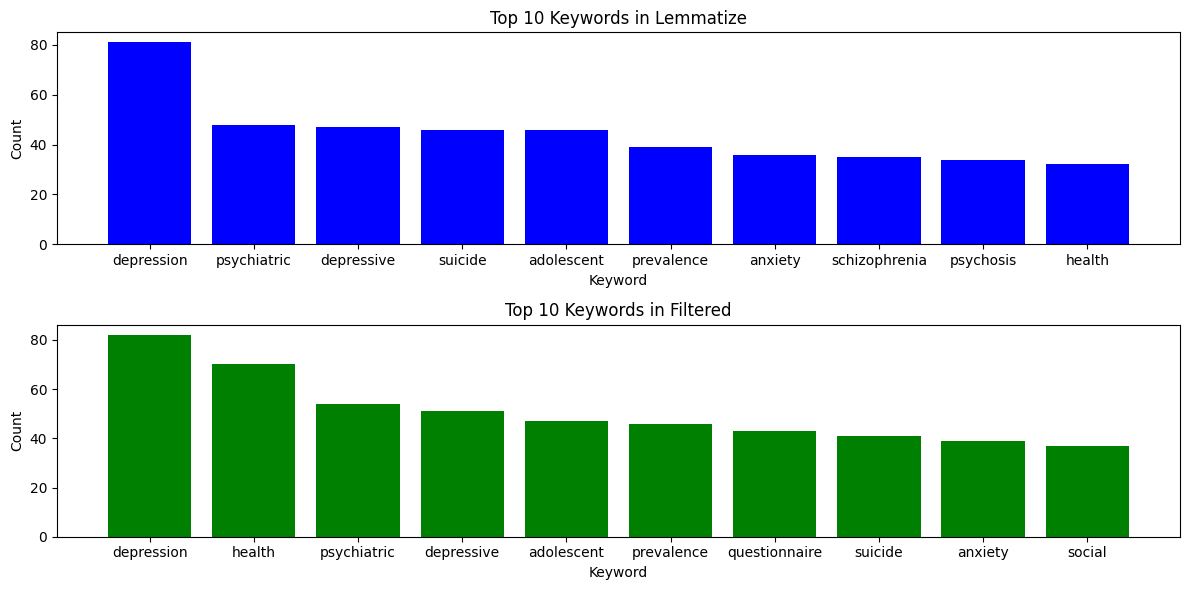

In [25]:
# same thing again, but what did the token filter do?

flat_a = [item.lower() for sublist in lemmatize_pipeline.run_data.results for item in sublist]
flat_b = [item.lower() for sublist in filter_pipeline.run_data.results for item in sublist]

set_a = set(flat_a)
set_b = set(flat_b)

intersection = set_a & set_b
only_a = set_a - set_b
only_b = set_b - set_a

# how many distinct keywords are in each pipeline
print(f"Number of keywords only in Lemmatize Only Pipeline: {len(only_a)}")
print(f"Number of keywords only in Filtered Pipeline: {len(only_b)}")
print(f"Number of keywords in both (intersection): {len(intersection)}\n")

# Count occurrences of keywords
count_a = Counter(flat_a)
count_b = Counter(flat_b)

n = 10

# Display the top n keywords by count for results
print("Top keywords in Lemmatize by count:")
top_a = count_a.most_common(n)
for keyword, count in top_a:
    print(f"{keyword}: {count}")

# Display the top 5 keywords by count for truths
print("\nTop keywords in Filtered by count:")
top_b = count_b.most_common(n)
for keyword, count in top_b:
    print(f"{keyword}: {count}")

# Create bar charts for top 5 keywords in each
fig, ax = plt.subplots(2,1, figsize=(12, 6))

# Plot for each list
ax[0].bar([item[0] for item in top_a], [item[1] for item in top_a], color='blue')
ax[0].set_title(f"Top {n} Keywords in Lemmatize")
ax[0].set_xlabel("Keyword")
ax[0].set_ylabel("Count")

ax[1].bar([item[0] for item in top_b], [item[1] for item in top_b], color='green')
ax[1].set_title(f"Top {n} Keywords in Filtered")
ax[1].set_xlabel("Keyword")
ax[1].set_ylabel("Count")

# Show the plots
plt.tight_layout()
plt.show()

## Predictive Labeling

From the above tests, we at least have a pretty good picture of the top 10 keywords in the "truths". since we're trying to match the truths in our performance metrics, let's use those as our possible labels.

Also, we haven't tested the new predictive labeling tools much yet. How does the MultiLogistic compare to the deep learning labeler? (Omitting the threshold vector similarity method for now since I haven't picked a good way to do threshold automatically yet).


In [31]:
# top 10 true keywords
possible_labels = ["mental health", "depression", "schizophrenia",
 "covid-19", "suicide", "anxiety", "loneliness",
 "psychosis", "epidemiology", "mental disorders"]

# make copies of abstracts
train, test = abstracts.split(ratio=0.3, seed=101)
train_1 = copy.deepcopy(train)
test_1 = copy.deepcopy(test)
train_2 = copy.deepcopy(train)
test_2 = copy.deepcopy(test)

# logistic regression pipeline

logistic_pipeline = Pipeline([
    {"name": "lemmatize", "method":"preprocess.Lemmatize"},
    {"name": "vectorize", "method":"vectorizer.SentenceEmbedding", "params":{"model_name":'all-MiniLM-L6-v2'}},
    {"name": "logistic", "method": "labeler.MultiLogistic"}
])

logistic_pipeline.set_data(train_data=train_1, run_data=test_1, possible_labels=possible_labels)

nn_pipeline = Pipeline([
    {"name": "lemmatize", "method":"preprocess.Lemmatize"},
    {"name": "vectorize", "method":"vectorizer.SentenceEmbedding", "params":{"model_name":'all-MiniLM-L6-v2'}},
    {"name": "logistic", "method": "labeler.SimpleNNLabeler"}
])

nn_pipeline.set_data(train_data=train_2, run_data=test_2, possible_labels=possible_labels)

#logistic_pipeline.run()
nn_pipeline.run()

#print("Logistic Regression Results")
#print(evaluate(logistic_pipeline.run_data))

print("Neural Net Results")
print(evaluate(nn_pipeline.run_data))

print(nn_pipeline.run_data.results[0:3])
print(nn_pipeline.run_data.truths[0:3])

Neural Net Results
{'precision_macro': 0.0, 'recall_macro': 0.0, 'f1_macro': 0.0, 'jaccard': 0.0525, 'exact_match_ratio': 0.0525}
[(), (), ()]
[['Depressive symptoms', 'Epidemiology', 'Sexual orientation', 'Social factors', 'Suicidal ideation', 'Young adults'], ['Genetic confounding', 'Modifiable lifestyle', 'Shared method variance', 'Adolescent internalizing problems'], ['Resilience', 'COVID-19', 'Mental health', 'Depression', 'Alzheimer’s disease']]


Well, at this moment we're at a point where the neural net learned to geneally never predict anything, and where the logistic regression has a bug. These need to be resolved, because this is not a good result or demo at all.